In [1]:
import numpy as np
import pandas as pd
from math import log, sqrt, pi, exp
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import functions as pf
from mpl_toolkits.axisartist.axislines import SubplotZero
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega
import pandas as pd
from pandas import DataFrame


import warnings
warnings.filterwarnings("ignore")

C:\Users\kroep\anaconda3\envs\standard_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kroep\anaconda3\envs\standard_env\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\kroep\anaconda3\envs\standard_env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\kroep\anaconda3\envs\standard_env\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def plot_function(f, x=np.linspace(0,3,100)):
    """
    Plots the given function with a central axis.

    Args:
        f (function): Function to be plotted.
        x (np.array, optional): Range of x-values. Defaults to np.linspace(0,3,100).
    """
    y = f(x)
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    plt.plot(x, y, 'b')
    plt.show()


def rw1D(steps, p=0.5):
    """
    Generates a 1D random walk.

    Args:
        steps (int): Number of steps in the random walk.
        p (float, optional): Probability for step direction. Defaults to 0.5.

    Returns:
        np.array: Random walk steps as (step_number, position) pairs.
    """
    M = [(0,0)]
    for k in range(1,steps):
        X_k = 1 if np.random.uniform(0,1) < p else -1
        M.append((k, M[k-1][1]+X_k))
    return np.array(M)


def ssrw1D(n, T, p=0.5):
    """
    Generates a scaled symmetric random walk.

    Args:
        n (int): Number of steps in the random walk.
        T (int): Total time.
        p (float, optional): Probability for step direction. Defaults to 0.5.

    Returns:
        np.array: Scaled random walk steps as (time, position) pairs.
    """
    M = rw1D(n*T, p)
    W = np.array(list(zip((1/n) * M[:,0], float(1 / np.sqrt(n)) * M[:,1])))
    return W

def plot_indicator_for_bm(n=1000, T=100, k=5, plot_simple_process=False):
    """
    Plots a Brownian motion and its associated indicator function.
    
    Args:
        n (int): Number of steps for each walk.
        T (int): Total time for the random walk.
        k (int): Scaling factor for steps.
        plot_simple_process (bool): If True, only plot the simple process.

    """
    # Generate a symmetric random walk to represent Brownian motion
    bm = ssrw1D(n, T, p=0.5)
    x = bm[:,0].copy().tolist()
    y = bm[:,1].copy().tolist()
    
    # Create the plot
    fig = plt.figure(figsize=(16,10))
    
    # Plot the Brownian motion path if requested
    if not plot_simple_process:
        plt.plot(x,y)

    # Prepare containers for the indicator function coordinates
    indicator_f_x = [x[0]]
    indicator_f_y = [y[0]]

    for i, yi in enumerate(y):
        # Every k*n steps, plot the indicator function segment and reset
        if i % (k*n) == 0:
            plt.plot(indicator_f_x, indicator_f_y, 'r')
            plt.plot(indicator_f_x[0], indicator_f_y[0], markersize=5, marker='o', markeredgecolor='red', markerfacecolor='red')
            plt.plot(indicator_f_x[-1], indicator_f_y[-1], markersize=5, marker='o', markeredgecolor='red', markerfacecolor='white')
            indicator_f_x = [x[i]]
            indicator_f_y = [y[i]]
        else:
            # Extend the current indicator function segment
            indicator_f_x.append(x[i])
            indicator_f_y.append(indicator_f_y[-1])

    # Plot the final indicator function segment
    plt.plot(indicator_f_x, indicator_f_y, 'r')
    plt.plot(indicator_f_x[0], indicator_f_y[0], markersize=5, marker='o', markeredgecolor='red', markerfacecolor='red')
    plt.plot(indicator_f_x[-1], indicator_f_y[-1], markersize=5, marker='o', markeredgecolor='red', markerfacecolor='white')

    # Set the plot labels
    plt.xlabel('t')
    if not plot_simple_process:
        plt.ylabel('W(t) and  ∆t')
    else:
        plt.ylabel('∆t')
    
    # Show the plot
    plt.show()

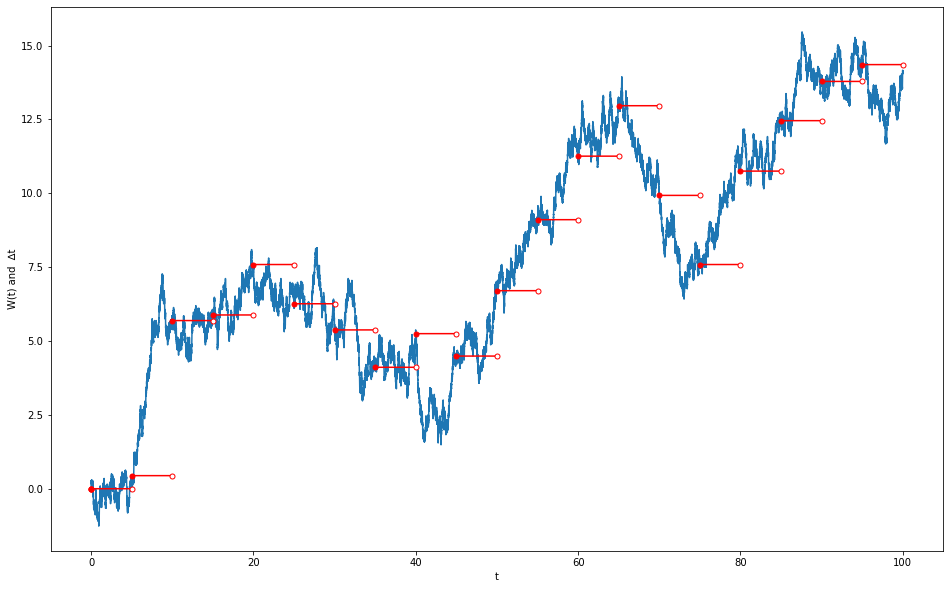

In [3]:
plot_indicator_for_bm()

In [4]:
def bm_zoom_3_plots(n=1000, T=1000, from_to=(0.6,0.8)):
    """
    Creates three plots to visualize different zoom levels of a Brownian motion path.
    
    Args:
        n (int): Number of steps for each walk.
        T (int): Total time for the random walk.
        from_to (tuple): A tuple with two elements representing the start and end 
                         fractions for zooming in on the path.

    """
    # Generate a symmetric random walk to represent Brownian motion
    bm = ssrw1D(n=n, T=T, p=0.5)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Get the x and y coordinates of the path
    x = bm[:,0].copy().tolist()
    y = bm[:,1].tolist()
    
    # Calculate indices for zooming in
    zoom_indices = (int(len(x) * from_to[0]), int(len(x) * from_to[1]))
    
    # Get the zoomed-in coordinates
    x1 = x[zoom_indices[0] : zoom_indices[1]]
    y1 = y[zoom_indices[0] : zoom_indices[1]]
    
    # Further zoom in
    zoom_indices2 = (int(len(x1) * from_to[0]), int(len(x1) * from_to[1]))
    x2 = x1[zoom_indices2[0] : zoom_indices2[1]]
    y2 = y1[zoom_indices2[0] : zoom_indices2[1]]
    
    # Plot the full path
    ax1.set(xlabel='t', ylabel='W(t)')
    ax1.plot(x, y)
    
    # Plot the first zoom level
    ax2.set(xlabel='t', ylabel='W(t)')
    ax2.plot(x1, y1)
    
    # Plot the second zoom level
    ax3.set(xlabel='t', ylabel='W(t)')
    ax3.plot(x2, y2)
    
    # Display the plots
    plt.show()

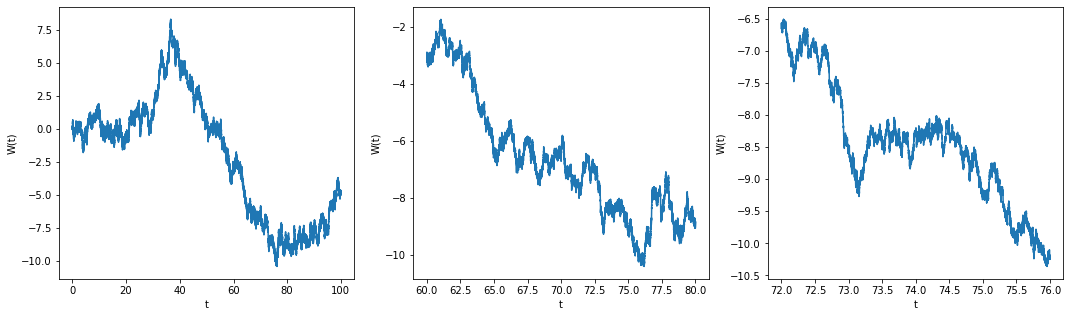

In [5]:
bm_zoom_3_plots(n=10000, T=100)

Distribution of paths at T=4:
  mu: -1.486
  var: 0.0



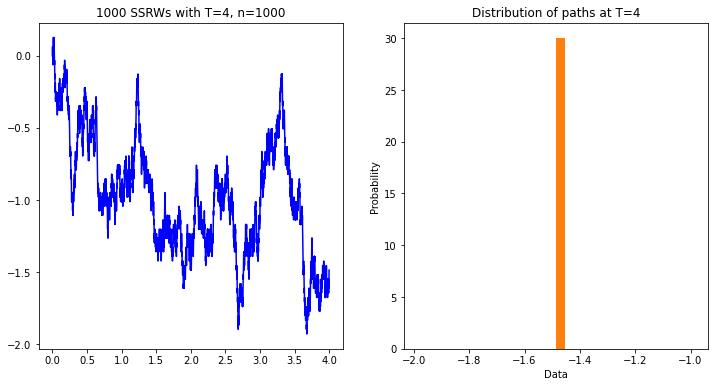

In [6]:
pf.plot_bm(num_tries=1, T=4)

### BS implied volatility with Newton

https://medium.com/swlh/calculating-option-premiums-using-the-black-scholes-model-in-python-e9ed227afbee

https://kevinpmooney.blogspot.com/2017/07/calculating-implied-volatility-from.html

In [7]:
def d1(S, K, t, T, r, sigma):
    """
    This function calculates d1 in the Black-Scholes formula.

    Parameters:
    S (float): The spot price of the underlying asset.
    K (float): The strike price of the option.
    t (float): The current time.
    T (float): The expiry time of the option.
    r (float): The risk-free interest rate.
    sigma (float): The volatility of the underlying asset.
    
    Returns:
    float: The calculated value of d1.
    """
    return (log(S/K) + (r + (sigma ** 2) / 2) * (T - t)) / (sigma * sqrt(T - t))


def d2(S, K, t, T, r, sigma):
    """
    This function calculates d2 in the Black-Scholes formula.
    Parameters are the same as for d1.
    
    Returns:
    float: The calculated value of d2.
    """
    return d1(S, K, t, T, r, sigma) - sigma * sqrt(T - t)


def bs_call(S, K, t, T, r, sigma):
    """
    This function calculates the price of a European call option using the Black-Scholes formula.

    Parameters are the same as for d1.
    
    Returns:
    float: The calculated price of the call option.
    """
    return S * norm.cdf(d1(S, K, t, T, r, sigma)) - K * exp(-r * (T - t)) * norm.cdf(d2(S, K, t, T, r, sigma))


def f(S, K, t, T, r, sigma, C0):
    """
    This function calculates the difference between the calculated Black-Scholes call option price and some target price.

    Parameters are the same as for d1, with one addition:
    C0 (float): The target call option price.
    
    Returns:
    float: The difference between the calculated and target prices.
    """
    return bs_call(S, K, t, T, r, sigma) - C0


def plot_bs_call(S, K, T, r, C0, sigma_list, t_list):
    """
    This function plots the difference between the calculated Black-Scholes call option price
    and some target price as a function of volatility.

    Parameters:
    S (float): The spot price of the underlying asset.
    K (float): The strike price of the option.
    T (float): The expiry time of the option.
    r (float): The risk-free interest rate.
    C0 (float): The target call option price.
    sigma_list (list of floats): A list of volatilities for which to calculate the price difference.
    t_list (list of floats): A list of times for which to calculate the price difference.
    """
    if max(t_list) > T:
        raise ValueError(f'{max(t_list)} in t_list is larger than T={T}.')
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1, 1, 1)
    
    colors_list = ['red', 'green', 'blue', 'orange', 'black', 'yellow']
    
    for index, t in enumerate(t_list):
        plt.plot(sigma_list, [f(S, K, t, T, r, sigma, C0) for sigma in sigma_list],
                 color=colors_list[index % len(colors_list)], label=f'\u03C4 = {round((T - t) * 365)}/365')
    
    plt.axhline(y=0, color='0.8', linestyle='-')
    plt.legend(loc="lower right")
    plt.xlabel('$\sigma$')
    plt.ylabel('$C(\sigma)-C_0$')
    plt.show()


def implied_vol(S0, K, T, r, market_price, tol=0.00001):
    """
    This function calculates the implied volatility of an European option using
    the Newton-Raphson method for root finding.

    Parameters:
    S0 (float): The initial stock price.
    K (float): The strike price.
    T (float): The expiry time of the option.
    r (float): The risk-free interest rate.
    market_price (float): The market price of the option.
    tol (float, optional): The tolerance for the Newton-Raphson method. Defaults to 0.00001.

    Returns:
    float: The implied volatility.
    """
    max_iter = 200  # Maximum number of iterations
    sigma = 0.3  # Initial guess

    for _ in range(max_iter):
        price_difference = bs_call(S0, K, 0, T, r, sigma) - market_price
        vega = S0 * sqrt(T) * norm.pdf(d1(S0, K, 0, T, r, sigma))

        if abs(price_difference) < tol:
            return sigma

        sigma -= price_difference / vega

    return sigma

#### Plot f for different imputs

In [8]:
def plot_bs_call(S,K,t,T,r,C0,sigma:list,
                 t_list:list, C0_list:list, S_list:list, K_list:list):
    """
    Plots the Black-Scholes call option price as a function of volatility, sigma, for different parameters. 
    It creates 4 subplots varying S (stock price), K (strike price), t (current time), and C0 (initial option price).

    Args:
        S (float): Stock price
        K (float): Strike price
        t (float): Current time
        T (float): Time of maturity
        r (float): Risk-free interest rate
        C0 (float): Initial option price
        sigma (list): A list of volatility values for which the function is calculated
        t_list (list): A list of different current time values to be plotted
        C0_list (list): A list of different initial option prices to be plotted
        S_list (list): A list of different stock prices to be plotted
        K_list (list): A list of different strike prices to be plotted
    """
    
    if max(t_list)>T:
        raise ValueError(f'{max(t_list)} in t_list is larger than T={T}.')
    
    figure, axis = plt.subplots(2, 2, figsize=(20,12))
    
    colors_list = ['red', 'green', 'blue', 'orange', 'black', 'yellow']
    
    for index, Si in enumerate(S_list):
        axis[0, 0].plot(sigma, f(S=Si,K=K,t=t,T=T,r=r,sigma=sigma,C0=C0),
                 color=colors_list[index], label=f'S = {Si}')
    
    for index, Ki in enumerate(K_list):
        axis[0, 1].plot(sigma, f(S=S,K=Ki,t=t,T=T,r=r,sigma=sigma,C0=C0),
                 color=colors_list[index], label=f'K = {Ki}')
    
    for index, ti in enumerate(t_list):
        axis[1, 0].plot(sigma, f(S=S,K=K,t=ti,T=T,r=r,sigma=sigma,C0=C0),
                 color=colors_list[index], label=f'\u03C4 = {round((T-ti)*365)}/365')
        
    for index, C0i in enumerate(C0_list):
        axis[1, 1].plot(sigma, f(S=S,K=K,t=t,T=T,r=r,sigma=sigma,C0=C0i),
                 color=colors_list[index], label=f'C0 = {C0i}')
    
    # Add common attributes to the subplots
    for ax in axis.flat:
        ax.axhline(y=0, color='0.7', linestyle='-')
        ax.legend(loc="upper left")
        ax.set_xlabel('$\sigma$')
        ax.set_ylabel('f($\sigma$)')
    
    # Add specific title for each subplot
    axis[0, 0].set_title('f($\sigma$) with varying S')
    axis[0, 1].set_title('f($\sigma$) with varying K')
    axis[1, 0].set_title('f($\sigma$) with varying $\\tau$')
    axis[1, 1].set_title('f($\sigma$) with varying C0')

    plt.show()

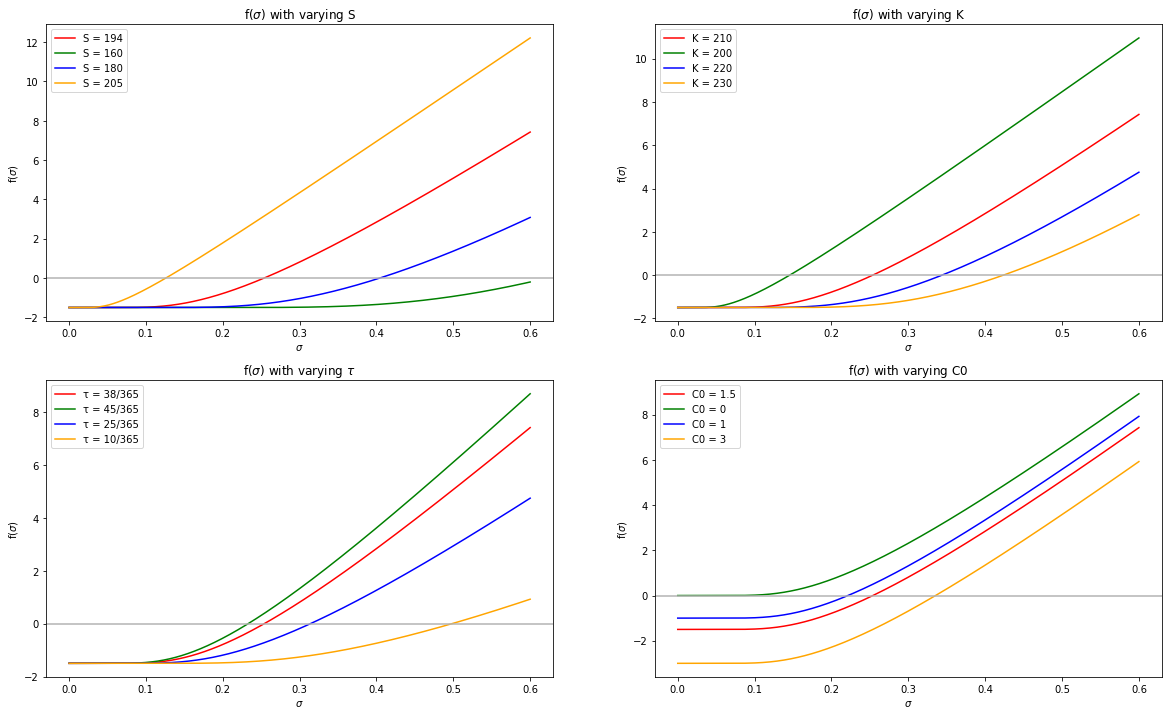

In [9]:
C0 = 1.5
S = 194
K = 210
tau = 38/365
T = 50/365
t = 12/365
r = 0.01
sigma = np.linspace(0,.6,1000)

plot_bs_call(S=S,K=K,t=t,T=T,r=r,C0=C0,sigma=sigma,
             t_list=[t, 5/365, 25/365,40/365],
             C0_list = [C0, 0, 1, 3],
             S_list = [S, 160, 180, 205],
             K_list = [K, 200, 220, 230])

In [10]:
def implied_vol(S, K, T, r, market_price, flag='c', tol=0.0001, plot=True, print_every_iter=True):
    """
    Calculates the implied volatility of an European option using Newton's method.
    
    Args:
        S (float): Stock price
        K (float): Strike price
        T (float): Time to maturity
        r (float): Risk-free rate
        market_price (float): Option price in market
        flag (str, optional): Type of option, 'c' for call and 'p' for put. Defaults to 'c'.
        tol (float, optional): Tolerance for the iterative method. Defaults to 0.0001.
        plot (bool, optional): If True, plots the estimation process. Defaults to True.
        print_every_iter (bool, optional): If True, prints intermediate values in each iteration. Defaults to True.

    Returns:
        float: The implied volatility that makes the Black-Scholes option price match the market price.
    """
    max_iter = 200 # max no. of iterations
    vol_old = 0.6  # initial guess
    sigma = np.linspace(0,.65,1000)
    
    if plot:
        fig, ax = plt.subplots(figsize=(20,12))
        plt.plot(sigma, f(S=S,K=K,t=12/365,T=50/365,r=r,sigma=sigma,C0=C0),
                 color='r', label=f'S = {S}')
        
        plt.scatter(vol_old, 0, color='lightskyblue')
        plt.plot([vol_old, vol_old], [0,float(bs(flag, S, K, T, r, vol_old)-market_price)], '--',
                 color='lightskyblue')
        
        plt.axhline(y=0, color='0.7', linestyle='-')
        plt.scatter(vol_old, f(S=S,K=K,t=12/365,T=50/365,r=r,sigma=vol_old,C0=C0), color='b')
        
        ax.set_xlabel('$\sigma$')
        ax.set_ylabel('f($\sigma$)')
    
    for k in range(max_iter):
        print(f'iter: {k}')
        bs_price = bs(flag, S, K, T, r, vol_old)
        Cprime = vega(flag, S, K, T, r, vol_old)*100
        C = bs_price - market_price
        vol_new = vol_old - C/Cprime
        
        if plot:
            plt.scatter(vol_new, 0, color='lightskyblue')
            plt.plot([vol_new,vol_new], [0,float(bs(flag, S, K, T, r, vol_new)-market_price)], '--',
                     color='lightskyblue')
            plt.scatter(vol_new, f(S=S,K=K,t=12/365,T=50/365,r=r,sigma=vol_new,C0=C0), color='b')
            plt.plot([vol_new,vol_old],[0,C], '--', color='lightskyblue')
            
        if print_every_iter:
            print(f'bs_price: {bs_price}')
            print(f'Cprime:   {Cprime}')
            print(f'C:        {C}')
            print(f'vol_new:  {vol_new}')
        
        new_bs_price = bs(flag, S, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break
        
        vol_old = vol_new
        print('')
    
    # add text (delete for other examples)
    ax.text(0.597, -0.2, '$\sigma_0$')
    ax.text(0.59, float(bs(flag, S, K, T, r, 0.6)-market_price)+0.2, '$f(\sigma_0)$')
    ax.text(0.285, -0.2, '$\sigma_1$')
    ax.text(0.28, float(bs(flag, S, K, T, r, 0.288)-market_price)+0.2, '$f(\sigma_1)$')
    ax.text(0.25, -0.2, '$\sigma_2$')
    ax.text(0.25, float(bs(flag, S, K, T, r, 0.25)-market_price)+0.3, '$f(\sigma_2)$')
        
    implied_vol = vol_new
    return implied_vol

iter: 0
bs_price: 8.926364574893544
Cprime:   23.821409421007914
C:        7.426364574893544
vol_new:  0.28824831295060604

iter: 1
bs_price: 2.0960061517375688
Cprime:   18.214840035142533
C:        0.5960061517375688
vol_new:  0.25552740238605137

iter: 2
bs_price: 1.5260957624863585
Cprime:   16.54567818095131
C:        0.026095762486358476
vol_new:  0.2539502072900896


0.2539502072900896

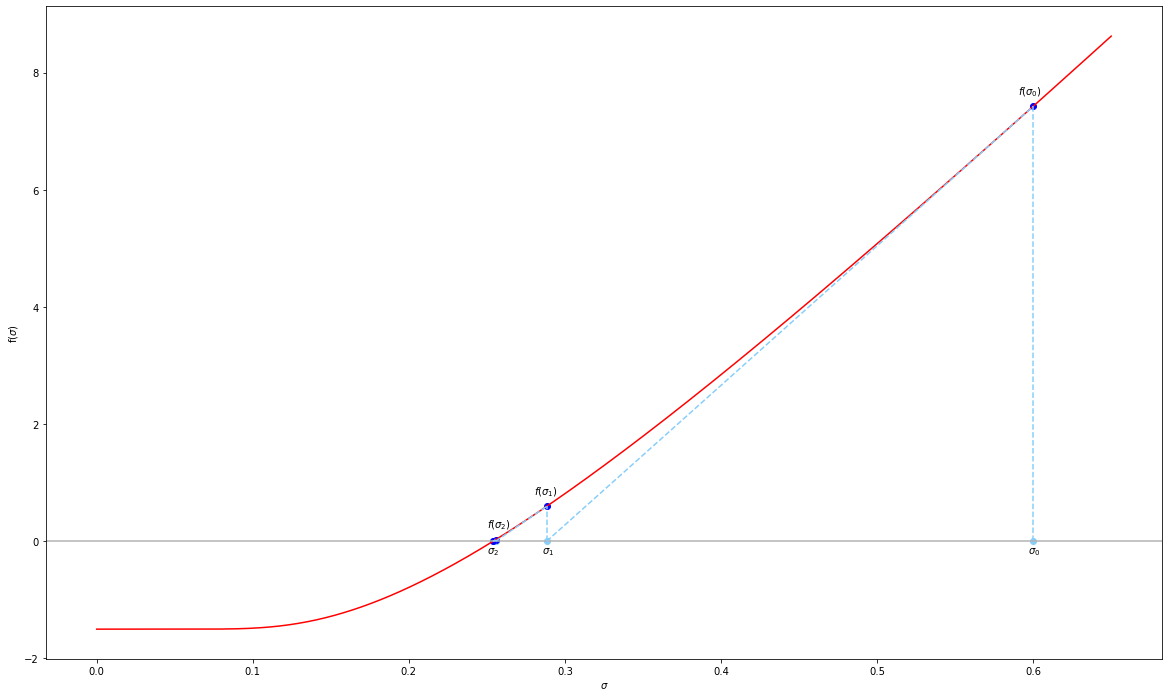

In [11]:
S = 194
K = 210
t = 38/365
r = 0.01
market_price = 1.5

implied_vol(S=S, K=K, T=t, r=r, market_price=market_price)

In [12]:
bs('c', S, K, t, r, 0.3)

2.313043327800099